In [1]:
import pandas
import numpy as np
import tensorflow as tf
import os
import math
import random as rand
from random import random

/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data Preparation

In [2]:
trainDataFile = 'ijcnlp_dailydialog/train/dialogues_train.txt'
trainLabelsFile = 'ijcnlp_dailydialog/train/dialogues_act_train.txt' 

In [3]:
testDataFile = 'ijcnlp_dailydialog/validation/dialogues_validation.txt'
testLablesFile = 'ijcnlp_dailydialog/validation/dialogues_act_validation.txt'

In [4]:
lineSeparator = '__eou__'

In [5]:
def getData(dialogueFile, labelFile):
    with open(dialogueFile) as f:
        lines = f.readlines() 
    with open(labelFile) as f:
        labels = f.readlines()    
    
    inputs = []
    inputs_all = []
    for line in lines:
        line = line.rstrip()
        line = line.split(lineSeparator)
        inputs.append(line[:-1])
        inputs_all.extend(line[:-1])
    
    acts = []
    acts_all = []
    for label in labels:
        label = label.rstrip()
        label = label.split()
        
        label = np.array(list(map(int, label))) - 1
        acts.append(label)
        acts_all.extend(label)
        
    return (inputs_all, inputs, acts_all, acts)

In [6]:
trainX_all, trainX_data, trainY_all, trainY = getData(trainDataFile, trainLabelsFile)
_, valX_data, valY_all, valY = getData(testDataFile, testLablesFile)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vect = CountVectorizer()
trainX_vocab = count_vect.fit(trainX_all)
vocab_dict = trainX_vocab.vocabulary_

# Might want to create a global vocabulary!!

In [8]:
embed_size = 300;
pad_token = '<pad>'
unknown_token = '<unk>'
embed_path = '../dataset/GloVe/glove.840B.300d.txt'

In [9]:
%matplotlib inline

from random import randint
import matplotlib

import numpy as np
import torch

torch.nn.Module.dump_patches = True

In [10]:
# sentEmbedModel = torch.load('encoder/infersent.allnli.pickle', map_location=lambda storage, loc: storage)

sentEmbedModel = torch.load('encoder/infersent.allnli.pickle')
sentEmbedModel = sentEmbedModel.cuda()

/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. Tried to save a patch, but couldn't create a writable file BLSTMEncoder.patch. Make sure it doesn't exist and your working directory is writable.
  warnings.warn(msg, SourceChangeWarning)
/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. Saved a reverse patch to LSTM.patch. Run `patch -p0 < LSTM.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)


In [11]:
sentEmbedModel.is_cuda()

True

In [12]:
sentEmbedModel.set_glove_path(embed_path)

In [13]:
sentEmbedModel.build_vocab_k_words(K=100000)

Vocab size : 100000


In [14]:
def create_sentence_embed_facebook(sentence):
#     print(sentence)
    embeddings = sentEmbedModel.encode([sentence], bsize=128, tokenize=False, verbose=False)
#     print(len(embeddings))
    return embeddings

# Train a classifier

In [15]:
# Parameters used.
MODEL_PATH = './model_crf_v4.ckpt'

In [16]:
def get_sequence_length(x_data):
    seq = [];
    for i in range(len(x_data)):
        seq.append(len(x_data[i]))
    return seq

In [17]:
x_train = trainX_data
y_train = trainY

x_test = valX_data
y_test = valY

sequence_length_train = get_sequence_length(x_train)
sequence_length_test = get_sequence_length(x_test)


In [18]:
learning_rate = 0.05
#training_epochs = 7
input_size = 4096 #sent_embed_size
#batch_size = 25
#num_units = 128 # the number of units in the LSTM cell
number_of_classes = len(set(trainY_all))

In [19]:
input_size

4096

In [20]:
def pad_label(sentence, max_length):
    pad_len = max_length - len(sentence)
    padding = np.zeros(pad_len, dtype=int)
    return np.concatenate((sentence, padding))

In [21]:
input_data = tf.placeholder(tf.float32, [None, None, input_size], name="input_data") # shape = (batch, batch_seq_len, input_size)
labels = tf.placeholder(tf.int32, shape=[None, None], name="labels") # shape = (batch, sentence)
batch_sequence_length = tf.placeholder(tf.int32) # max sequence length in batch
original_sequence_lengths = tf.placeholder(tf.int32, [None])


In [22]:
weights = tf.get_variable("weights", [input_size, number_of_classes])
matricized_x_train = tf.reshape(input_data, [-1, input_size])
matricized_unary_scores = tf.matmul(matricized_x_train, weights)
#matricized_unary_scores = tf.sigmoid(matricized_unary_scores_temp)
scores = tf.reshape(matricized_unary_scores, [-1, batch_sequence_length, number_of_classes])
#scores = tf.reshape(matricized_unary_scores, [num_examples, num_words, num_tags])


In [23]:
# Linear-CRF.
log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(scores, labels, original_sequence_lengths)

loss = tf.reduce_mean(-log_likelihood)

# Compute the viterbi sequence and score (used for prediction and test time).
viterbi_sequence, viterbi_score = tf.contrib.crf.crf_decode(scores, transition_params, original_sequence_lengths)

# Training ops.
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [24]:
def pad_data(sentence, max_length, input_size):
#     sent_emb = np.array([create_sentence_embed(x, word_emb, embed_size, unknown_token, pad_token, calc_mean = True) for x in sentence])
    sent_emb = np.array([create_sentence_embed_facebook(x) for x in sentence])
    pad_len = max_length - len(sentence)
    temp = sent_emb
    if pad_len > 0:
        single_pad = np.zeros(input_size)
        padding = [single_pad] * pad_len
#         print(pad_len)
#         print(len(sent_emb), len(padding))
#         print(type(sent_emb), type(padding))
#         print(sent_emb.shape)
        sent_emb = sent_emb.squeeze()
        temp = np.concatenate((sent_emb, padding))
    return temp

In [25]:
def batch(data, labels, sequence_lengths, batch_size, input_size):
    n_batch = int(math.ceil(float(len(data)) / (batch_size)))
    index = 0
    for _ in range(n_batch):
#         print(_)
        batch_sequence_lengths = np.array(sequence_lengths[index: index + batch_size])
#         print(batch_sequence_lengths)
        batch_length = np.array(max(batch_sequence_lengths)) # max length in batch
#         print(batch_length)
#         for x in data[index: index + batch_size]:
#             xx = pad_data(x, batch_length, input_size)
#             print(xx.shape)
        batch_data = np.array([pad_data(x, batch_length, input_size).squeeze() for x in data[index: index + batch_size]]) # pad data
        batch_labels = np.array([pad_label(x, batch_length) for x in labels[index: index + batch_size]]) # pad labels
        index += batch_size
        
        # Reshape input data to be suitable for LSTMs.
        batch_data = batch_data.reshape(-1, batch_length, input_size)
        
        yield batch_data, batch_labels, batch_length, batch_sequence_lengths

In [28]:
%%time 
training_epochs = 30;
batch_size = 800;
cnt = 0;
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    for i in range(training_epochs):
        for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_train, y_train, sequence_length_train, batch_size, input_size):
            cnt += 1
            tf_viterbi_sequence, _ = session.run([viterbi_sequence, train_op], 
                                                 feed_dict={input_data: batch_data, 
                                                            labels: batch_labels, 
                                                            batch_sequence_length: batch_seq_len,
                                                            original_sequence_lengths: batch_sequence_lengths })
            # Show train accuracy.
            if i % 1 == 0:
                # Create a mask to fix input lengths.
                mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
                    np.expand_dims(batch_sequence_lengths, axis=1))
                total_labels = np.sum(batch_sequence_lengths)
                correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
                accuracy = 100.0 * correct_labels / float(total_labels)
                print("Epoch: %d" % i, "Accuracy: %.2f%%" % accuracy)
#             if (cnt*batch_size) % 10000 ==0:
    # Save the variables to disk.
                print("Saving model")
#         saver.save(session, MODEL_PATH)

/home/aananya/Work/GenderBiasAnalysis/InferSent/PGM/models.py:209: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  sentences[stidx:stidx + bsize]), volatile=True)


Epoch: 0 Accuracy: 12.80%
Epoch: 0 Accuracy: 58.80%
Epoch: 0 Accuracy: 49.65%
Epoch: 0 Accuracy: 68.08%
Epoch: 0 Accuracy: 70.94%
Epoch: 0 Accuracy: 68.91%
Epoch: 0 Accuracy: 29.08%
Epoch: 0 Accuracy: 56.28%
Epoch: 0 Accuracy: 46.35%
Epoch: 0 Accuracy: 51.76%
Epoch: 0 Accuracy: 66.86%
Epoch: 0 Accuracy: 65.40%
Epoch: 0 Accuracy: 63.89%
Epoch: 0 Accuracy: 65.39%
Epoch: 1 Accuracy: 65.83%
Epoch: 1 Accuracy: 57.05%
Epoch: 1 Accuracy: 67.37%
Epoch: 1 Accuracy: 73.06%
Epoch: 1 Accuracy: 76.25%
Epoch: 1 Accuracy: 74.97%
Epoch: 1 Accuracy: 63.04%
Epoch: 1 Accuracy: 62.78%
Epoch: 1 Accuracy: 64.41%
Epoch: 1 Accuracy: 68.85%
Epoch: 1 Accuracy: 62.45%
Saving model
Epoch: 1 Accuracy: 62.34%
Epoch: 1 Accuracy: 69.60%
Epoch: 1 Accuracy: 70.39%
Epoch: 2 Accuracy: 83.14%
Epoch: 2 Accuracy: 81.91%
Epoch: 2 Accuracy: 80.72%
Epoch: 2 Accuracy: 77.90%
Epoch: 2 Accuracy: 77.64%
Epoch: 2 Accuracy: 77.31%
Epoch: 2 Accuracy: 70.22%
Epoch: 2 Accuracy: 71.35%
Epoch: 2 Accuracy: 70.61%
Epoch: 2 Accuracy: 70.62%

KeyboardInterrupt: 

In [83]:
a = 1

In [26]:
%%time
# Testing the model.
with tf.Session() as session:
    # Restore variables from disk.
    saver.restore(session, MODEL_PATH)
    
    for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_test, y_test, sequence_length_test, len(x_test), input_size):
        tf_viterbi_sequence = session.run(viterbi_sequence, feed_dict={input_data: batch_data, 
                                                                       labels: batch_labels, 
                                                                       batch_sequence_length: batch_seq_len,
                                                                       original_sequence_lengths: batch_sequence_lengths })
    # mask to correct input sizes
    mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
        np.expand_dims(batch_sequence_lengths, axis=1))
    total_labels = np.sum(batch_sequence_lengths)
    correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
    accuracy = 100.0 * correct_labels / float(total_labels)
    print("Test accuracy: %.2f%%" % accuracy)

    print("Label:", batch_labels[0].astype(int))    
    print("Pred.:", tf_viterbi_sequence[0])

INFO:tensorflow:Restoring parameters from ./model_crf_v4.ckpt


/home/aananya/Work/GenderBiasAnalysis/InferSent/PGM/models.py:209: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  sentences[stidx:stidx + bsize]), volatile=True)


InternalError: Blas GEMM launch failed : a.shape=(31000, 4096), b.shape=(4096, 4), m=31000, n=4, k=4096
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Reshape, weights/read)]]
	 [[Node: cond_2/rnn/while/Exit_2/_73 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_133_cond_2/rnn/while/Exit_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'MatMul', defined at:
  File "/home/aananya/app/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/aananya/app/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/aananya/app/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/aananya/app/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/aananya/app/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-17ece50e00e1>", line 3, in <module>
    matricized_unary_scores = tf.matmul(matricized_x_train, weights)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 2122, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4279, in mat_mul
    name=name)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/aananya/Work/GenderBiasAnalysis/InferSent/.venvInferSent/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(31000, 4096), b.shape=(4096, 4), m=31000, n=4, k=4096
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Reshape, weights/read)]]
	 [[Node: cond_2/rnn/while/Exit_2/_73 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_133_cond_2/rnn/while/Exit_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


# Evaluation

In [30]:
from sklearn import metrics

In [31]:
preds = []
for i in range(len(sequence_length_test)):
    preds.extend(tf_viterbi_sequence[i][:sequence_length_test[i]])

In [32]:
metrics.accuracy_score(valY_all, preds)

0.7734539595984633

In [33]:
print(metrics.classification_report(valY_all, preds))

             precision    recall  f1-score   support

          0       0.74      0.87      0.80      3125
          1       0.88      0.94      0.91      2244
          2       0.74      0.52      0.61      1775
          3       0.64      0.52      0.57       925

avg / total       0.77      0.77      0.76      8069



In [34]:
cmat = metrics.confusion_matrix(valY_all, preds)

In [35]:
cmat.diagonal()/cmat.sum(axis=1)

array([0.87392   , 0.93538324, 0.52450704, 0.51891892])

In [36]:
cmat

array([[2731,   47,  168,  179],
       [  32, 2099,  104,    9],
       [ 550,  216,  931,   78],
       [ 372,   18,   55,  480]])

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
import itertools

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
classes = ['inform', 'question', 'directive', 'commisive']

Confusion matrix, without normalization
[[2731   47  168  179]
 [  32 2099  104    9]
 [ 550  216  931   78]
 [ 372   18   55  480]]


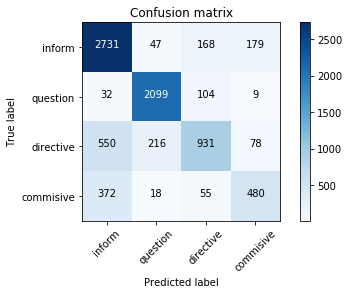

In [41]:
plot_confusion_matrix(cmat, classes)

Normalized confusion matrix
[[0.87392    0.01504    0.05376    0.05728   ]
 [0.01426025 0.93538324 0.04634581 0.0040107 ]
 [0.30985915 0.12169014 0.52450704 0.04394366]
 [0.40216216 0.01945946 0.05945946 0.51891892]]


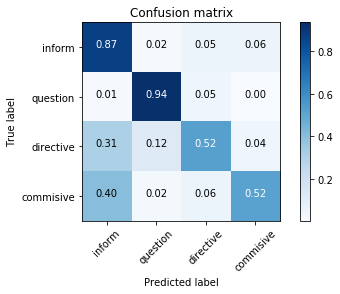

In [42]:
plot_confusion_matrix(cmat, classes, normalize=True)

In [43]:
correctPerClass = {}
totalPerClass   = {}
for cls in [0, 1, 2, 3]:
    correctPerClass[cls] = 0
    totalPerClass[cls]   = 0
for yt, yp in zip(valY_all, preds):
    totalPerClass[yt] += 1
    correctPerClass[yt] += int(yt==yp)



In [44]:
totalPerClass

{0: 3125, 1: 2244, 2: 1775, 3: 925}

In [45]:
correctPerClass

{0: 2731, 1: 2099, 2: 931, 3: 480}

In [46]:
for cls in [0, 1, 2, 3]:
    acc = float(correctPerClass[cls])/totalPerClass[cls]
    print("Accuracy for class ", cls, " :", acc)

Accuracy for class  0  : 0.87392
Accuracy for class  1  : 0.9353832442067737
Accuracy for class  2  : 0.5245070422535211
Accuracy for class  3  : 0.518918918918919


# Saving the transition params

In [47]:
x = tf.Variable([[1.0, 2.0], [3, 1]])

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
v = sess.run(transition_params)    

In [48]:
np.savetxt('transition_params_crf_v2.csv', v, delimiter=',')